In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import pickle
from sklearn.decomposition import PCA
import george
from george import kernels
from scipy.optimize import minimize

In [2]:
import schwimmbad
import emcee
import dynesty.plotting as dyplot
import dynesty.results as dyres
import dynesty.utils as dyfunc
import dynesty
import corner
import time
import sys

In [3]:
paramvals=np.load("slice_params.npy")
weights=np.load("slice_weights.npy")

In [4]:
def load_pcwpar(param,weight):
    return np.array(paramvals[param]).reshape(-1,1), np.array(weights[param][weight])

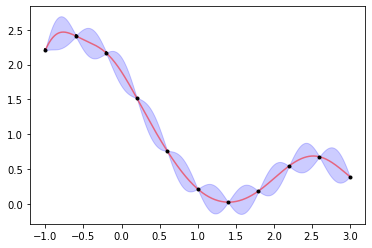

Initial ln-likelihood: -15.13
initial param vector:  [-0.31055756 -2.40794561]


In [5]:
X, y = load_pcwpar(1,6)
yerr=[j*0.01 for j in y]

kernel = kernels.ExpSquaredKernel(.3**2) * np.var(y)

gp = george.GP(kernel)
gp.compute(X,yerr)

x_pred = np.linspace(-1,3,500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(x_pred, pred, "r", lw=1.5, alpha=0.5)
plt.errorbar(X, y, yerr,fmt=".k", capsize=0)
plt.show()

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
print("initial param vector: ", gp.get_parameter_vector())

[ 0.08226546 -0.2536942 ]
[1.0419904  0.88086835]

Final ln-likelihood: 3.50


<ErrorbarContainer object of 3 artists>

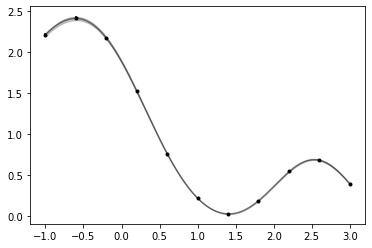

In [6]:

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
#print(result)
print(gp.get_parameter_vector())
print(np.sqrt(np.exp(gp.get_parameter_vector())))

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(X, y, yerr, fmt=".k", capsize=0)

In [7]:
ndim = 2

#def gp_model(p,x):
#    gp.set_parameter_vector(p)
#    pred,pred_var=gp.predict(y,x)
#    return pred

def loglike (p,x,y,yerr):
    #model = gp_model(p,x)
    #sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    #return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2)) 
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y)

def ptform(u):
    #  [-50,50] and [-4.6,1.4]
    p=[u[0]*1000 -500, u[1]*6-4.6]
    return p

In [8]:
sampler = dynesty.NestedSampler(loglike, ptform, \
        ndim,nlive=1000,logl_args=(X,y,yerr), pool=schwimmbad.MultiPool())
t0=time.time()
sampler.run_nested()
print(time.time()-t0)
results = sampler.results

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results)

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(results)

KeyboardInterrupt: 

In [9]:
def ptform(u):
    #  [-50,50] and [-4.6,1.4]
    p=[u[0]*10 -5, u[1]*6-4.6]
    return p

In [10]:
sampler = dynesty.NestedSampler(loglike, ptform, \
        ndim,nlive=1000,logl_args=(X,y,yerr), pool=schwimmbad.MultiPool())
t0=time.time()
sampler.run_nested()
print(time.time()-t0)
results = sampler.results

iter: 5018 | +1000 | bound: 3 | nc: 1 | ncall: 39097 | eff(%): 15.392 | loglstar:   -inf <  3.503 <    inf | logz: -1.290 +/-  0.090 | dlogz:  0.001 >  1.009                                         

37.87151002883911


In [15]:
results

         nlive: 1000
         niter: 5018
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 15.392485356932758
       samples: array([[-4.82011122,  1.34220081],
       [-4.67996731,  1.35497552],
       [-4.87565498,  1.28033544],
       ...,
       [ 0.10323558, -0.2457379 ],
       [ 0.11012412, -0.24789911],
       [ 0.09520437, -0.25133278]])
    samples_id: array([374, 615, 721, ..., 875, 300, 387])
    samples_it: array([   0,    0,    0, ..., 4832, 1811, 4982])
     samples_u: array([[0.01798888, 0.9903668 ],
       [0.03200327, 0.99249592],
       [0.0124345 , 0.98005591],
       ...,
       [0.51032356, 0.72571035],
       [0.51101241, 0.72535015],
       [0.50952044, 0.72477787]])
         logwt: array([-6103.88362609, -5833.04987358, -5623.5476972 , ...,
          -8.42206428,    -8.42181379,    -8.42128244])
          logl: array([-6.09628172e+03, -5.82544697e+03, -5.61594380e+03, ...,
        3.50240962e+00,  3.50245771e+00,  3.50347205e+00])
        logvol: 

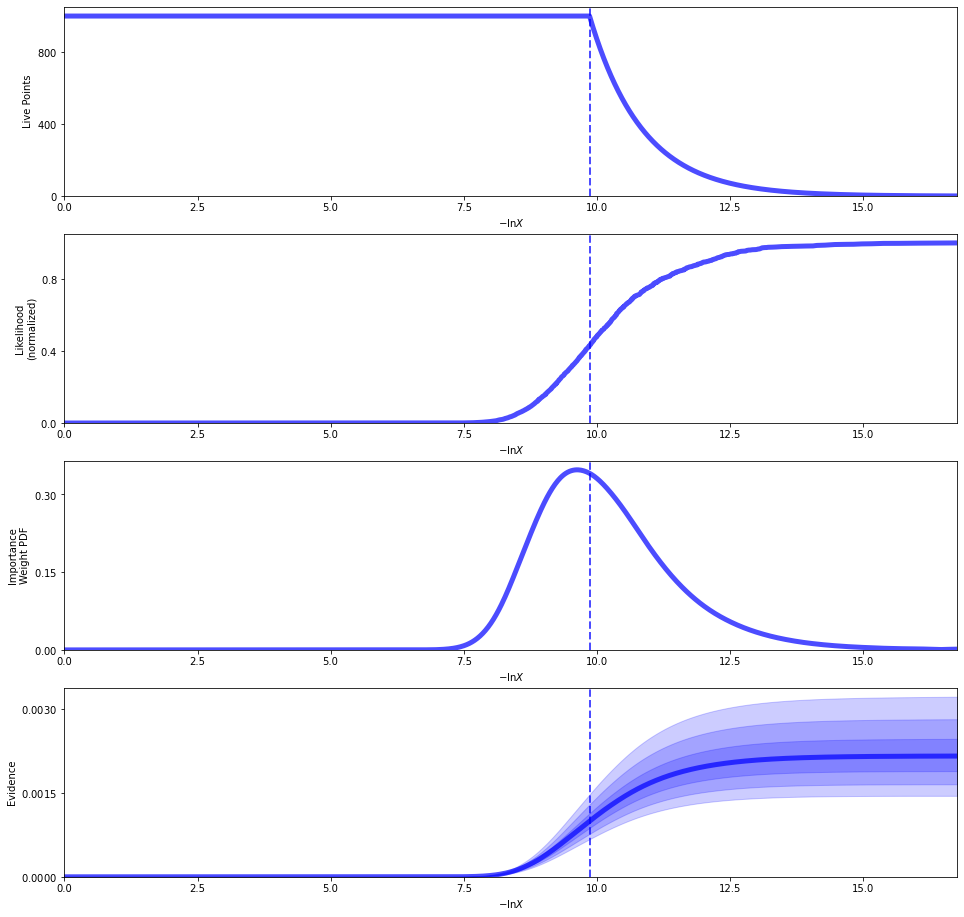

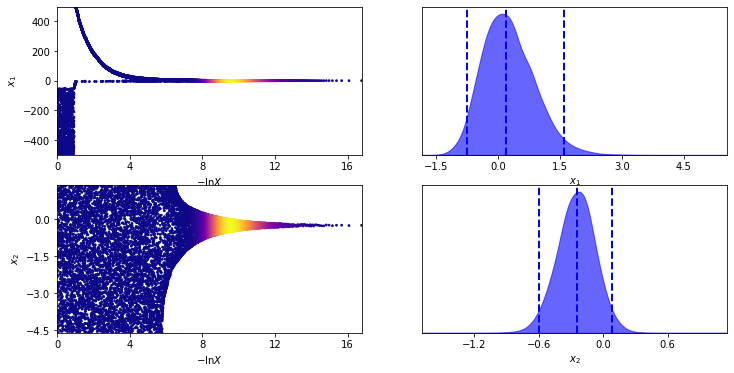

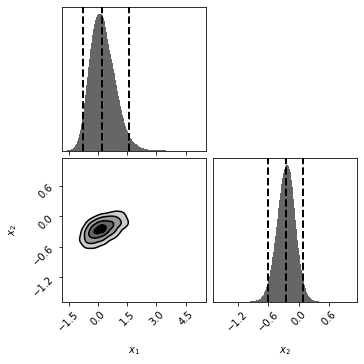

In [10]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results)

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(results)

In [32]:
def ptform(u):
    #  [-1,1] and [-4.6,1.4]
    p=[u[0]*2 -1, u[1]*6-4.6]
    return p

In [27]:
sampler = dynesty.NestedSampler(loglike, ptform, \
        ndim,nlive=1000,logl_args=(X,y,yerr), pool=schwimmbad.MultiPool())
t0=time.time()
sampler.run_nested()
print(time.time()-t0)
results = sampler.results

iter: 3515 | +1000 | bound: 0 | nc: 1 | ncall: 33541 | eff(%): 13.461 | loglstar:   -inf <  3.501 <    inf | logz:  0.246 +/-  0.059 | dlogz:  0.001 >  1.009                                         

8.754398107528687


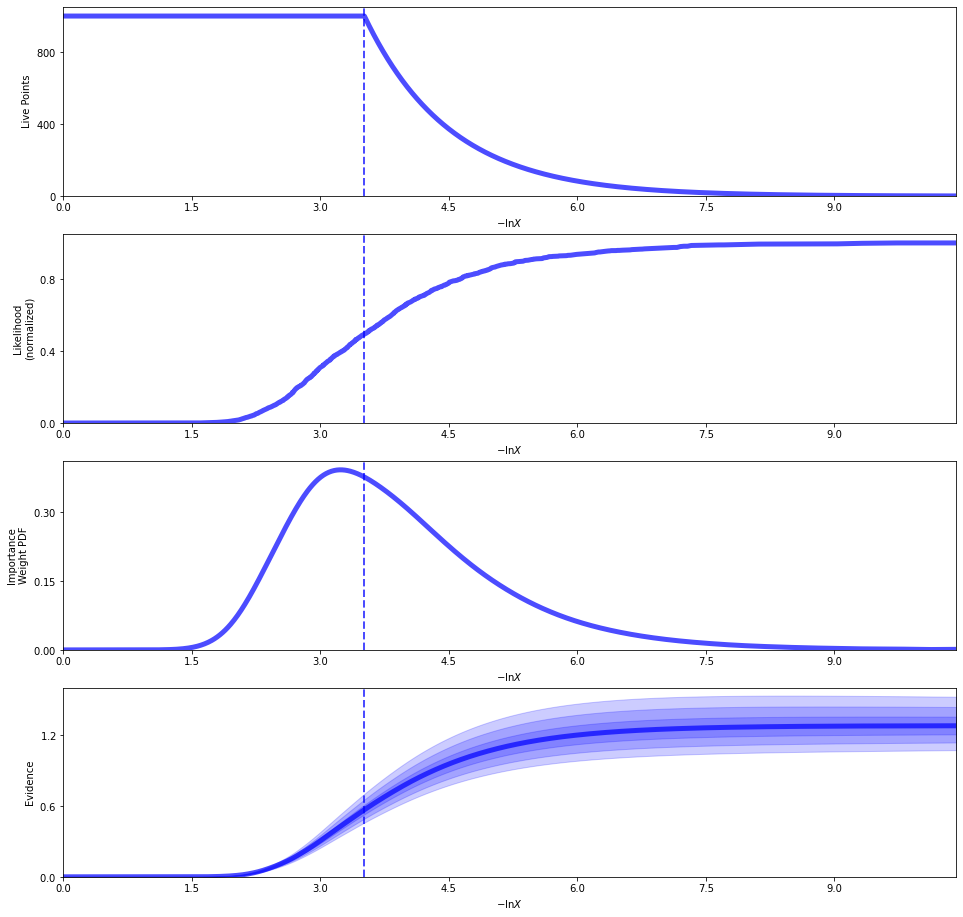

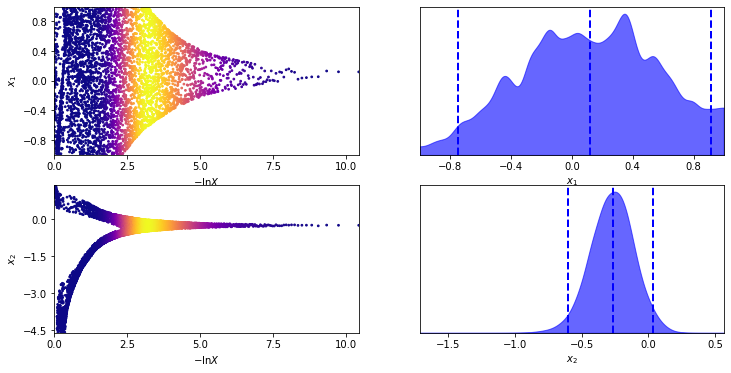

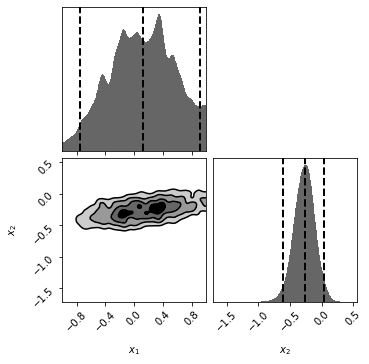

In [28]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results)

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(results)